In [1]:
import numpy as np
import pandas as pd

In [2]:
#DATA COLLECTION
df = pd.read_csv("Dataset-SA.csv")
df.shape



(205052, 6)

In [3]:
#DATA CLEANING
df.isna().sum()

product_name         0
product_price        0
Rate                 0
Summary          24664
Review              11
Sentiment            0
dtype: int64

In [4]:
df.dropna(subset=['Review', 'Sentiment'], inplace=True)

In [5]:
df.isna().sum()

product_name         0
product_price        0
Rate                 0
Summary          24662
Review               0
Sentiment            0
dtype: int64

In [6]:
print(df.duplicated().sum())


34374


In [7]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)


In [8]:
df.shape


(170667, 6)

In [9]:
print(df['Sentiment'].value_counts())

Sentiment
positive    134695
negative     26473
neutral       9499
Name: count, dtype: int64


In [10]:
#DATA PREPROCESSING AND FEATURE EXTRACTION

import re
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'[^A-Za-z\s]', '', text) 
    tokens = word_tokenize(text)  
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]  
    return " ".join(lemmatized_words) 
df['Cleaned_Review'] = df['Review'].astype(str).apply(preprocess_text)
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_df=0.85, min_df=3, stop_words='english', sublinear_tf=True, dtype=np.float32)
X = tfidf.fit_transform(df['Cleaned_Review'])
feature_names = tfidf.get_feature_names_out()  
tfidf_df = pd.DataFrame(X.toarray(), columns=feature_names)
for i in range(5):  
    print(f"\nReview {i+1}:")
    review_words = df['Cleaned_Review'].iloc[i].split()
    tfidf_scores = {word: tfidf_df.iloc[i][word] for word in review_words if word in tfidf_df.columns}
    
    for word, score in tfidf_scores.items():
        print(f"{word}: {score:.4f}")
le = LabelEncoder()
df['Sentiment'] = le.fit_transform(df['Sentiment']) 


Review 1:
great: 0.1682
cooler: 0.2435
excellent: 0.1579
air: 0.2277
flow: 0.2906
price: 0.1406
amazing: 0.1720
unbelievablejust: 0.4098
love: 0.1761

Review 2:
best: 0.1768
budget: 0.2789
fit: 0.2891
cooler: 0.3160
nice: 0.1256
cooling: 0.3175

Review 3:
quality: 0.1949
good: 0.1319
power: 0.3923
air: 0.4119
decent: 0.4293

Review 4:
bad: 0.2843
product: 0.1484
fan: 0.4360

Review 5:
ok: 0.5948
product: 0.1622


In [11]:
from scipy.sparse import vstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

In [37]:
#TRAINING WITH MACHINE LEARNING MODELS 

X = tfidf.fit_transform(df['Cleaned_Review'])
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
models = {
    "AL-LR": LogisticRegression(C=200, max_iter=30000, penalty='l2', solver='saga'),
    "AL-KNN": KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
    "AL-RF": RandomForestClassifier(n_estimators=350, max_depth=20),
    "AL-GB": GradientBoostingClassifier(n_estimators=350, learning_rate=0.05),
    "AL-DT": DecisionTreeClassifier(max_depth=15)
}
n_queries = 3  
chunk_size = 200  
results = []
for model_name, model in models.items():
    print(f"\nTraining Model: {model_name}")
    X_training = X_train_resampled[:chunk_size]
    y_training = y_train_resampled[:chunk_size]
    X_pool = X_train_resampled[chunk_size:]  
    y_pool = y_train_resampled[chunk_size:]

    for query in range(n_queries):
        print(f"Query {query + 1}")
        model.fit(X_training, y_training)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision_micro = precision_score(y_test, y_pred, average='micro')
        recall_micro = recall_score(y_test, y_pred, average='micro')
        f1_micro = f1_score(y_test, y_pred, average='micro')

        precision_weighted = precision_score(y_test, y_pred, average='weighted')
        recall_weighted = recall_score(y_test, y_pred, average='weighted')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')

        results.append([
            f"Iteration {query + 1}", model_name, accuracy,
            precision_micro, recall_micro, f1_micro,
            precision_weighted, recall_weighted, f1_weighted
        ])

        print(f"{model_name}: Accuracy={accuracy*100:.3f}, Micro-F1={f1_micro:.3f}, Weighted-F1={f1_weighted:.3f}")

        
        if hasattr(model, "predict_proba"):  
            probabilities = model.predict_proba(X_pool)
            uncertainty = 1 - np.max(probabilities, axis=1)  
            query_idx = np.argsort(uncertainty)[-chunk_size:] 
        else:
            query_idx = np.random.choice(np.arange(len(X_pool)), chunk_size, replace=False)

        X_training = vstack([X_training, X_pool[query_idx]])  
        y_training = np.hstack([y_training, y_pool.iloc[query_idx]])

results_df = pd.DataFrame(results, columns=[
    "Iteration", "Model", "Accuracy", 
    "Precision (Micro)", "Recall (Micro)", "F1-Score (Micro)",
    "Precision (Weighted)", "Recall (Weighted)", "F1-Score (Weighted)"
])



Training Model: AL-LR
Query 1
AL-LR: Accuracy=82.614, Micro-F1=0.826, Weighted-F1=0.782
Query 2
AL-LR: Accuracy=86.633, Micro-F1=0.866, Weighted-F1=0.850
Query 3
AL-LR: Accuracy=86.879, Micro-F1=0.869, Weighted-F1=0.861

Training Model: AL-KNN
Query 1
AL-KNN: Accuracy=84.012, Micro-F1=0.840, Weighted-F1=0.811
Query 2
AL-KNN: Accuracy=28.759, Micro-F1=0.288, Weighted-F1=0.370
Query 3
AL-KNN: Accuracy=30.337, Micro-F1=0.303, Weighted-F1=0.391

Training Model: AL-RF
Query 1


c:\Users\sujith011\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AL-RF: Accuracy=78.924, Micro-F1=0.789, Weighted-F1=0.696
Query 2


c:\Users\sujith011\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AL-RF: Accuracy=80.655, Micro-F1=0.807, Weighted-F1=0.736
Query 3


c:\Users\sujith011\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AL-RF: Accuracy=43.925, Micro-F1=0.439, Weighted-F1=0.475

Training Model: AL-GB
Query 1
AL-GB: Accuracy=84.016, Micro-F1=0.840, Weighted-F1=0.813
Query 2
AL-GB: Accuracy=84.866, Micro-F1=0.849, Weighted-F1=0.826
Query 3
AL-GB: Accuracy=85.461, Micro-F1=0.855, Weighted-F1=0.836

Training Model: AL-DT
Query 1
AL-DT: Accuracy=83.307, Micro-F1=0.833, Weighted-F1=0.806
Query 2
AL-DT: Accuracy=83.178, Micro-F1=0.832, Weighted-F1=0.806
Query 3
AL-DT: Accuracy=66.216, Micro-F1=0.662, Weighted-F1=0.719


In [38]:
#EVALUATION METRICS(RESULT)
results_df

,Iteration,Model,Accuracy,Precision (Micro),Recall (Micro),F1-Score (Micro),Precision (Weighted),Recall (Weighted),F1-Score (Weighted)
0,Iteration 1,AL-LR,0.826136,0.826136,0.826136,0.826136,0.825879,0.826136,0.781814
1,Iteration 2,AL-LR,0.866331,0.866331,0.866331,0.866331,0.856634,0.866331,0.849826
2,Iteration 3,AL-LR,0.868792,0.868792,0.868792,0.868792,0.858383,0.868792,0.861110
3,Iteration 1,AL-KNN,0.840120,0.840120,0.840120,0.840120,0.829061,0.840120,0.810735
4,Iteration 2,AL-KNN,0.287592,0.287592,0.287592,0.287592,0.867034,0.287592,0.370115
5,Iteration 3,AL-KNN,0.303373,0.303373,0.303373,0.303373,0.880590,0.303373,0.390765
6,Iteration 1,AL-RF,0.789242,0.789242,0.789242,0.789242,0.777999,0.789242,0.696296
7,Iteration 2,AL-RF,0.806547,0.806547,0.806547,0.806547,0.777980,0.806547,0.735888
8,Iteration 3,AL-RF,0.439249,0.439249,0.439249,0.439249,0.796350,0.439249,0.475122
9,Iteration 1,AL-GB,0.840159,0.840159,0.840159,0.840159,0.829775,0.840159,0.812614


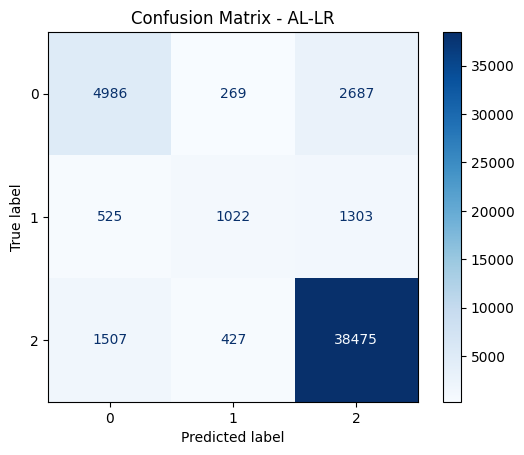

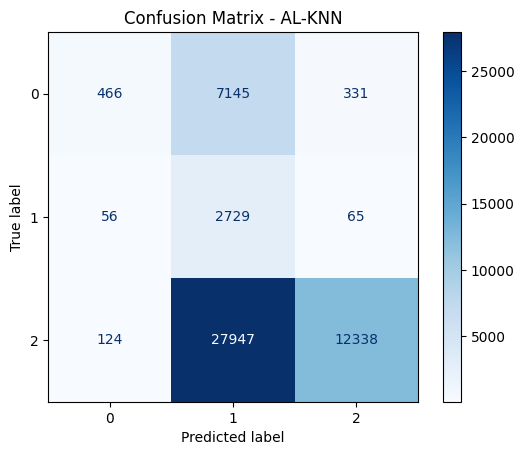

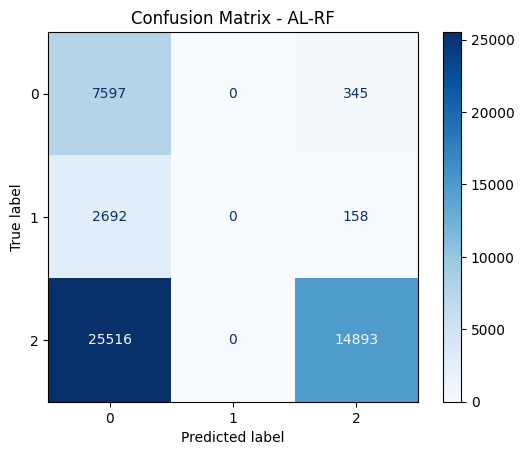

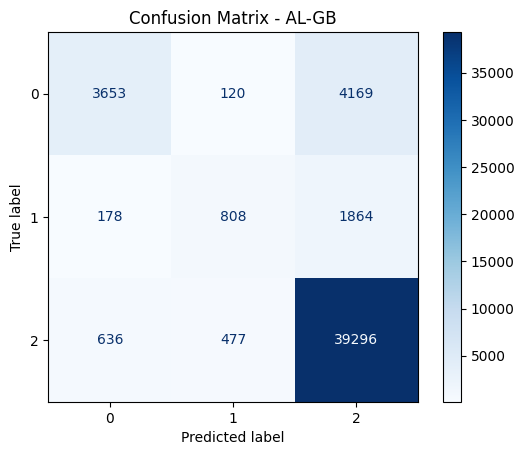

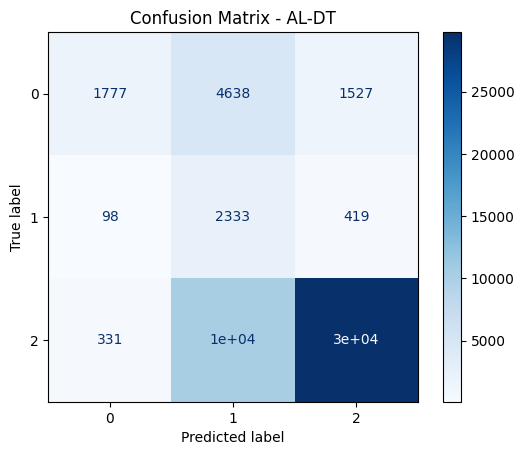

In [ ]:
#CONFUSION MATRIX OF EACH MODEL

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.grid(False)
    plt.show()


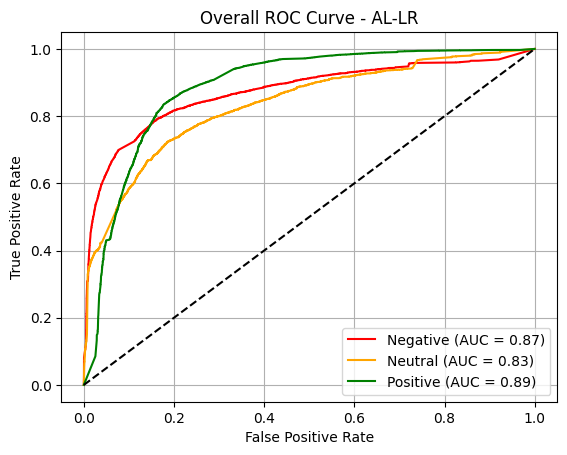

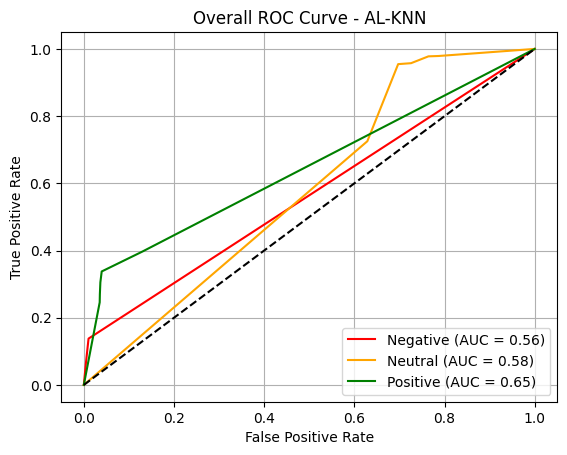

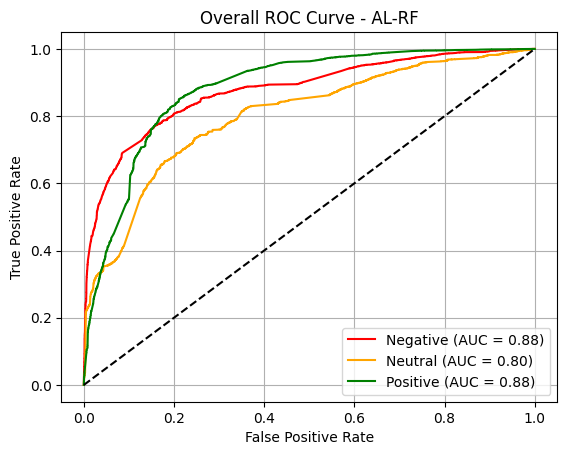

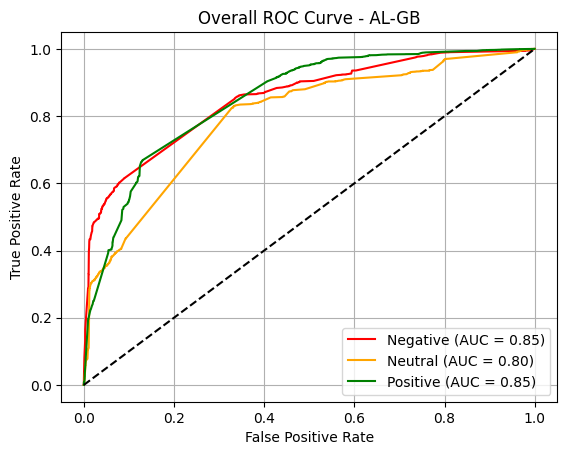

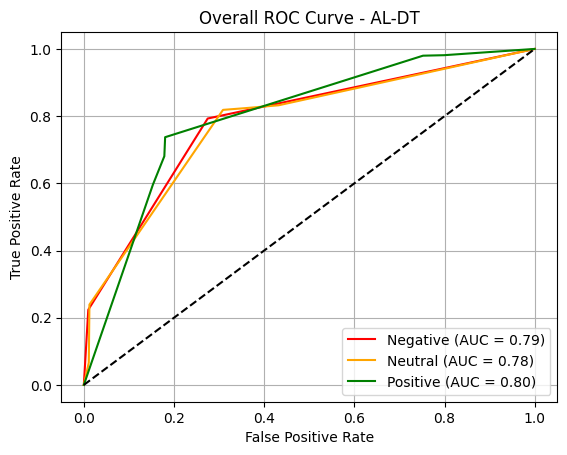

In [ ]:
#ROC CURVE AND AUC CURVES

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

for model_name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        continue

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['red', 'orange', 'green']
    class_labels = ['Negative', 'Neutral', 'Positive']
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Overall ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [ ]:
#EVALUATION METRICS FOR EACH CLASSES

import pandas as pd

class_indices = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

negative_results = []
neutral_results = []
positive_results = []

for model_name, model in models.items():
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    accuracy = accuracy_score(y_test, y_pred)

    negative_results.append([model_name, accuracy, precision[0], recall[0], f1[0]])
    neutral_results.append([model_name, accuracy, precision[1], recall[1], f1[1]])
    positive_results.append([model_name, accuracy, precision[2], recall[2], f1[2]])

table_columns = ["Model", "Accuracy", "Precision", "Recall", "F1-Score"]

table_negative = pd.DataFrame(negative_results, columns=table_columns)
table_neutral = pd.DataFrame(neutral_results, columns=table_columns)
table_positive = pd.DataFrame(positive_results, columns=table_columns)
print("Negative Sentiment")
display(table_negative)

print("Neutral Sentiment")
display(table_neutral)

print("Positive Sentiment")
display(table_positive)


c:\Users\sujith011\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Negative Sentiment


,Model,Accuracy,Precision,Recall,F1-Score
0,AL-LR,0.868792,0.710459,0.627802,0.666578
1,AL-KNN,0.303373,0.721362,0.058675,0.108524
2,AL-RF,0.439249,0.212177,0.956560,0.347315
3,AL-GB,0.854612,0.817775,0.459960,0.588766
4,AL-DT,0.662155,0.805530,0.223747,0.350217


Neutral Sentiment


,Model,Accuracy,Precision,Recall,F1-Score
0,AL-LR,0.868792,0.594878,0.358596,0.447461
1,AL-KNN,0.303373,0.072156,0.957544,0.134199
2,AL-RF,0.439249,0.000000,0.000000,0.000000
3,AL-GB,0.854612,0.575089,0.283509,0.379788
4,AL-DT,0.662155,0.135199,0.818596,0.232070


Positive Sentiment


,Model,Accuracy,Precision,Recall,F1-Score
0,AL-LR,0.868792,0.906040,0.952139,0.928518
1,AL-KNN,0.303373,0.968902,0.305328,0.464332
2,AL-RF,0.439249,0.967329,0.368557,0.533751
3,AL-GB,0.854612,0.866906,0.972457,0.916653
4,AL-DT,0.662155,0.938687,0.737286,0.825886
